In [1]:
import numpy as np
import tempfile
import tensorflow as tf

from tf_rl.controller import DiscreteDeepQ, HumanController
from tf_rl.simulation import KarpathyGame
from tf_rl import simulate
from tf_rl.models import MLP

In [20]:
LOG_DIR = tempfile.mkdtemp()
print(LOG_DIR)

/tmp/tmp3rSEdd


In [316]:
from random import randint, gauss

import numpy as np

class DiscreteHill(object):
    
    directions = [(0,1), (0,-1), (1,0), (-1,0)]
    
    def __init__(self, board=(10,10), variance=4.):
        self.variance = variance
        self.target = (0, 0)
        while self.target == (0, 0):
            self.target   = (randint(-board[0], board[0]), randint(-board[1], board[1]))
        self.position = (0, 0)
    
    @staticmethod
    def add(p, q):
        return (p[0] + q[0], p[1] + q[1])
        
    @staticmethod
    def distance(p, q):
        return abs(p[0] - q[0]) + abs(p[1] - q[1])
    
    def estimate_distance(self, p):
        distance = DiscreteHill.distance(self.target, p) - DiscreteHill.distance(self.target, self.position)
        return distance + abs(gauss(0, self.variance))
        
    def observe(self):    
        return np.array([self.estimate_distance(DiscreteHill.add(self.position, delta)) 
                         for delta in DiscreteHill.directions])
    
    def perform_action(self, action):
        self.position = DiscreteHill.add(self.position, DiscreteHill.directions[action])
        
    def is_over(self):
        return self.position == self.target
    
    def collect_reward(self, action):
        return -DiscreteHill.distance(self.target, DiscreteHill.add(self.position, DiscreteHill.directions[action])) \
            + DiscreteHill.distance(self.target, self.position) - 2

In [329]:
n_prev_frames = 3

# Tensorflow business - it is always good to reset a graph before creating a new controller.
tf.ops.reset_default_graph()
session = tf.InteractiveSession()

# This little guy will let us run tensorboard
#      tensorboard --logdir [LOG_DIR]
journalist = tf.train.SummaryWriter(LOG_DIR)

# Brain maps from observation to Q values for different actions.
# Here it is a done using a multi layer perceptron with 2 hidden
# layers
brain = MLP([n_prev_frames * 4 + n_prev_frames - 1,], [4], 
            [tf.identity])

# The optimizer to use. Here we use RMSProp as recommended
# by the publication
optimizer = tf.train.RMSPropOptimizer(learning_rate= 0.001, decay=0.9)

# DiscreteDeepQ object
current_controller = DiscreteDeepQ(n_prev_frames * 4 + n_prev_frames - 1, 4, brain, optimizer, session,
                                   discount_rate=0.9, exploration_period=100, max_experience=10000, 
                                   store_every_nth=1, train_every_nth=4, target_network_update_rate=0.1,
                                   summary_writer=journalist)

session.run(tf.initialize_all_variables())
session.run(current_controller.target_network_update)
# graph was not available when journalist was created  
journalist.add_graph(session.graph_def)

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7fa0300f42d0>> ignored


In [330]:
performances = []

try:
    for game_idx in range(10000):
        game = DiscreteHill()
        game_iterations = 0

        observation = game.observe()
        
        prev_frames = [(observation, -1)] * (n_prev_frames - 1)
        memory = np.concatenate([np.concatenate([observation, np.array([-1])])] * (n_prev_frames - 1) + [observation])
        
        while game_iterations < 50 and not game.is_over():
            action = current_controller.action(memory)
            if n_prev_frames > 1:
                prev_frames = prev_frames[1:] + [(observation, action)]
            reward = game.collect_reward(action)
            game.perform_action(action)
            observation = game.observe()
            new_memory = np.concatenate([np.concatenate([a, np.array([b])]) for (a, b) in prev_frames] + [observation])
            current_controller.store(memory, action, reward, new_memory)
            current_controller.training_step()
            memory = new_memory
            game_iterations += 1
            cost = abs(game.target[0]) + abs(game.target[1])
        performances.append((game_iterations - cost) / float(cost))
        if game_idx % 100 == 0:
            print "\rGame %d: iterations before success %d." % (game_idx, game_iterations),
            print "Pos: %s, Target: %s" % (game.position, game.target),
except KeyboardInterrupt:
    print "Interrupted"

Game 9900: iterations before success 16. Pos: (6, 6), Target: (6, 6)


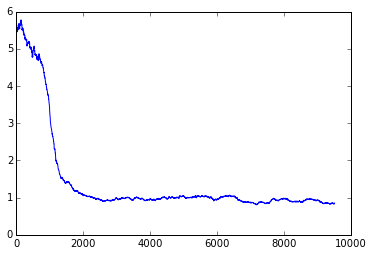

In [327]:
N = 500
smooth_performances = [float(sum(performances[i:i+N])) / N for i in range(0, len(performances) - N)]

plt.plot(range(len(smooth_performances)), smooth_performances)

<matplotlib.colorbar.Colorbar instance at 0x7fa050305dd0>

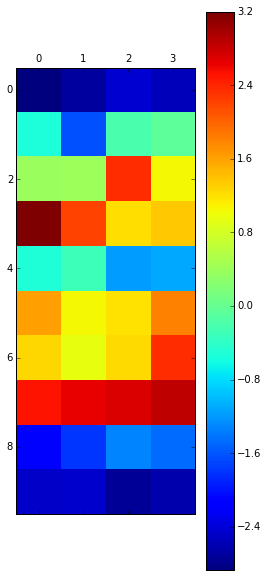

In [231]:
x = brain.layers[0].Ws[0].eval()
import matplotlib.pyplot as plt
%matplotlib inline
plt.matshow(x)
plt.colorbar()

In [138]:
brain.input_layer.b.eval()

array([ 11.01352692,  11.28201485,  12.03692055,  12.26954937], dtype=float32)

In [88]:
game.collect_reward(0)

-2.0

In [269]:
np.concatenate([observation, np.array([-1])])

array([ 1.39407934,  2.791605  ,  0.92194436,  1.73143704, -1.        ])

In [278]:
n_prev_frames

1

In [285]:
action

1

In [294]:
performances[:10]

[]

In [306]:
performances_1 = performances[:]

In [328]:
np.average(performances[-1000:])

0.89357223079637949

In [ ]:
np